In [ ]:
!pip install einops

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./train_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./test_data/', train=False, transform=transforms.ToTensor(), download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [14]:
from typing import List, Optional
import torch
import torch.nn as nn
from torch.nn import Module
from torch import Tensor, int32
from einops import rearrange

def round_ste(z: Tensor) -> Tensor:
    """Round with straight through gradients."""
    zhat = z.round()
    return z + (zhat - z).detach()

# main class
class FSQ(Module):
    def __init__(
        self,
        levels: List[int],
        eps: float = 1e-3,
    ):
        super().__init__()
        self._eps = eps

        _levels = torch.tensor(levels, dtype=int32)
        self.register_buffer("_levels", _levels, persistent = False)

        _basis = torch.cumprod(torch.tensor([1] + levels[:-1]), dim=0, dtype=int32)
        self.register_buffer("_basis", _basis, persistent = False)

        self.codebook_dim = len(levels)
        self.codebook_size = self._levels.prod().item()

        implicit_codebook = self.indices_to_codes(torch.arange(self.codebook_size), project_out = False)
        self.register_buffer("implicit_codebook", implicit_codebook, persistent = False)

    def bound(self, z: Tensor) -> Tensor:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels - 1) * (1 - self._eps) / 2
        offset = torch.where(self._levels % 2 == 1.0, 0.0, 0.5)
        shift = (offset / half_l).tan()
        return (z + shift).tanh() * half_l - offset

    def quantize(self, z: Tensor) -> Tensor:
        """Quantizes z, returns quantized zhat, same shape as z."""
        quantized = round_ste(self.bound(z))
        half_width = self._levels // 2 # Renormalize to [-1, 1].
        return quantized / half_width

    def _scale_and_shift(self, zhat_normalized: Tensor) -> Tensor:
        # Scale and shift to range [0, ..., L-1]
        half_width = self._levels // 2
        return (zhat_normalized * half_width) + half_width

    def _scale_and_shift_inverse(self, zhat: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indices(self, zhat: Tensor) -> Tensor:
        """Converts a `code` to an index in the codebook."""
        assert zhat.shape[-1] == self.codebook_dim
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(dim=-1).to(int32)

    def indices_to_codes(
        self,
        indices: Tensor,
        project_out = True
    ) -> Tensor:
        """Inverse of `codes_to_indices`."""
        indices = rearrange(indices, '... -> ... 1')
        codes_non_centered = (indices // self._basis) % self._levels
        codes = self._scale_and_shift_inverse(codes_non_centered)
        return codes

In [25]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim, nclass, ncond):
        super(VAE, self).__init__()

        self.fsq = FSQ(levels=[5]*z_dim)

        # encoder part
        self.fc1 = nn.Linear(x_dim+ncond, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc21 = nn.Linear(h_dim2, h_dim2)
        self.fc22 = nn.Linear(h_dim2, h_dim2)
        self.fc23 = nn.Linear(h_dim2, h_dim2)
        self.fc3 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim+ncond, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        # default values for generation
        self.label_embedding = nn.Embedding(nclass, ncond)

    def encoder(self, x, label):
        x = torch.cat((x, label), dim=1)
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc21(h))
        h = F.relu(self.fc22(h))
        h = F.relu(self.fc23(h))
        return self.fc3(h)

    def decoder(self, zhat, label):
        zhat = torch.cat((zhat, label), dim=1)
        h = F.relu(self.fc4(zhat))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))

    def forward(self, x, label):
        label = self.label_embedding(label)
        z = self.encoder(x.view(-1, 784), label)
        zhat = self.fsq.quantize(z)
        return self.decoder(zhat + (z-zhat).detach(), label)

    def generate(self, label):
        label = torch.tensor([label]).cuda()
        label = self.label_embedding(label)
        indices = torch.randint(self.fsq.codebook_dim, size=(label.shape[0],)).cuda()
        z = self.fsq.indices_to_codes(indices)
        return self.decoder(z, label)

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=512, z_dim=10, nclass=10, ncond=64)
vae.cuda()

VAE(
  (fsq): FSQ()
  (fc1): Linear(in_features=848, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc21): Linear(in_features=512, out_features=512, bias=True)
  (fc22): Linear(in_features=512, out_features=512, bias=True)
  (fc23): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (fc4): Linear(in_features=74, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
  (label_embedding): Embedding(10, 64)
)

In [26]:
optimizer = optim.Adam(vae.parameters(), lr=5e-5)
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    return BCE

In [17]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.cuda()
        label = label.cuda()

        optimizer.zero_grad()
        recon_batch = vae(data, label)
        loss = loss_function(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [18]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, label in test_loader:
            data = data.cuda()
            label = label.cuda()
            recon = vae(data,label)

            # sum up batch loss
            test_loss += loss_function(recon, data).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [27]:
for epoch in range(50):
    train(epoch)
    test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 544.783281
Train Epoch: 0 [10000/60000 (17%)]	Loss: 217.573477
Train Epoch: 0 [20000/60000 (33%)]	Loss: 211.140996
Train Epoch: 0 [30000/60000 (50%)]	Loss: 193.554375
Train Epoch: 0 [40000/60000 (67%)]	Loss: 181.028672
Train Epoch: 0 [50000/60000 (83%)]	Loss: 176.143359
====> Epoch: 0 Average loss: 226.4922
====> Test set loss: 175.5013
Train Epoch: 1 [0/60000 (0%)]	Loss: 176.195039
Train Epoch: 1 [10000/60000 (17%)]	Loss: 164.992285
Train Epoch: 1 [20000/60000 (33%)]	Loss: 175.863711
Train Epoch: 1 [30000/60000 (50%)]	Loss: 169.287539
Train Epoch: 1 [40000/60000 (67%)]	Loss: 167.265566
Train Epoch: 1 [50000/60000 (83%)]	Loss: 166.888438
====> Epoch: 1 Average loss: 169.2466
====> Test set loss: 161.4690
Train Epoch: 2 [0/60000 (0%)]	Loss: 167.170762
Train Epoch: 2 [10000/60000 (17%)]	Loss: 164.646777
Train Epoch: 2 [20000/60000 (33%)]	Loss: 148.421309
Train Epoch: 2 [30000/60000 (50%)]	Loss: 152.117578
Train Epoch: 2 [40000/60000 (67%)]	Loss: 147.51

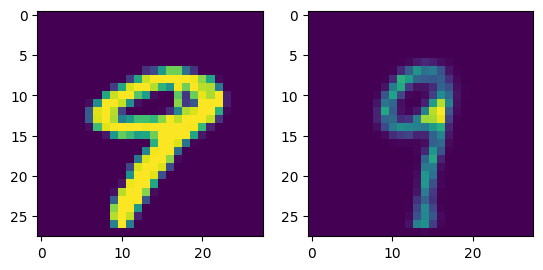

In [40]:
from matplotlib import pyplot as plt
from einops import rearrange

img, label = test_dataset[9]
with torch.no_grad():
  gen_img = vae.generate(label)
  img = rearrange(img, 'c h w -> h w c')
  gen_img = rearrange(gen_img.cpu(), 'c (h w) -> h w c', h=img.shape[0])
  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.subplot(1,2,2)
  plt.imshow(gen_img)